
# Tf-Idf transformation

<div align="center"> 
    <img src="https://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="width: 150px;"/>
</div>

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Clean-Clean ER in the link discovery/deduplication between two sets of entities.


## How to install?

pyJedAI is an open-source library that can be installed from PyPI.


In [ ]:
%pip install pyjedai -U

In [ ]:
%pip show pyjedai

Imports

In [1]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation
from pyjedai.datamodel import Data
d1 = pd.read_csv("../data/ccer/D2/abt.csv", sep='|', engine='python')
d2 = pd.read_csv("../data/ccer/D2/buy.csv", sep='|', engine='python')
gt = pd.read_csv("../data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    id_column_name_1='id',
    dataset_2=d2,
    id_column_name_2='id',
    ground_truth=gt
)

# Simple workflow

In [2]:
from pyjedai.block_building import StandardBlocking
from pyjedai.block_cleaning import BlockFiltering
from pyjedai.block_cleaning import BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning
from pyjedai.matching import EntityMatching

sb = StandardBlocking()
blocks = sb.build_blocks(data)
sb.evaluate(blocks, with_classification_report=True)

cbbp = BlockPurging()
blocks = cbbp.process(blocks, data, tqdm_disable=False)
cbbp.evaluate(blocks, with_classification_report=True)

bf = BlockFiltering(ratio=0.8)
blocks = bf.process(blocks, data, tqdm_disable=False)

wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(blocks, data)
wep.evaluate(candidate_pairs_blocks, with_classification_report=True)

/home/conda/miniconda3/envs/pypi_dependencies/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Standard Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

Standard Blocking: 100%|██████████| 2152/2152 [00:00<00:00, 20775.30it/s]


***************************************************************************************************************************
                                         Method:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.1049 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.08% 
	Recall:        99.81%
	F1-score:       0.15%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1074
	False positives: 1406781
	True negatives: 1156698
	False negatives: 2
	Total comparisons: 1407855
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Block Purging: 100%|██████████| 4266/4266 [00:00<00:00, 462839.21it/s]


***************************************************************************************************************************
                                         Method:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 13920.0
Runtime: 0.0110 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.25% 
	Recall:        99.81%
	F1-score:       0.49%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1074
	False positives: 436832
	True negatives: 1156698
	False negatives: 2
	Total comparisons: 437906
──────────────────────────────────────────────────────────────────────────────────────────

Cardinality Edge Pruning: 100%|██████████| 1076/1076 [00:02<00:00, 532.97it/s]

***************************************************************************************************************************
                                         Method:  Cardinality Edge Pruning
***************************************************************************************************************************
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 2.0199 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      7.32% 
	Recall:        93.77%
	F1-score:      13.58%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1009
	False positives: 12773
	True negatives: 1156633
	False negatives: 67
	Total comparisons: 13782
───────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 7.32114352053403,
 'Recall %': 93.77323420074349,
 'F1 %': 13.581908736034462,
 'True Positives': 1009,
 'False Positives': 12773,
 'True Negatives': 1156633,
 'False Negatives': 67}

## Entity Matching with Tf-Idf configuration

Available options with `metric='tf-idf'``:
```
tokenizer = {   'tfidf_char_1gram', ..., 'tfidf_char_6gram',
                'tfidf_word_1gram', ..., 'tfidf_word_6gram',
                'tf_char_1gram', ... , 'tf_char_6gram',
                'tf_word_1gram', ... , 'tf_word_6gram',
                'boolean_char_1gram', ... , 'boolean_char_6gram'
                'boolean_word_1gram', ... , 'boolean_word_6gram'                
```

where: 

- `tdidf` literal calculates tf-idf in the whole dataset using TdidfVectorizer
- `tf` literal calculates tf  in the whole dataset using CountVectorizer
- `boolean` literal transforms tf-idf matrix to boolean

and available metrics for vector similarity metric:

- `metric = ['dice', 'jaccard', 'cosine']`


In [3]:
em = EntityMatching(metric='cosine', 
                    tokenizer='char_tokenizer',
                    vectorizer='tfidf',
                    qgram=3,
                    similarity_threshold=0.0)
pairs_graph = em.predict(candidate_pairs_blocks, data)
em.evaluate(pairs_graph)

Entity Matching (cosine, char_tokenizer): 100%|██████████| 1073/1073 [00:00<00:00, 2605.80it/s]

***************************************************************************************************************************
                                         Method:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: cosine
	Attributes: None
	Similarity threshold: 0.0
	Tokenizer: char_tokenizer
	Vectorizer: tfidf
	Qgrams: 3
Runtime: 0.4132 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      7.32% 
	Recall:        93.77%
	F1-score:      13.58%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 7.32114352053403,
 'Recall %': 93.77323420074349,
 'F1 %': 13.581908736034462,
 'True Positives': 1009,
 'False Positives': 12773,
 'True Negatives': 1156633,
 'False Negatives': 67}

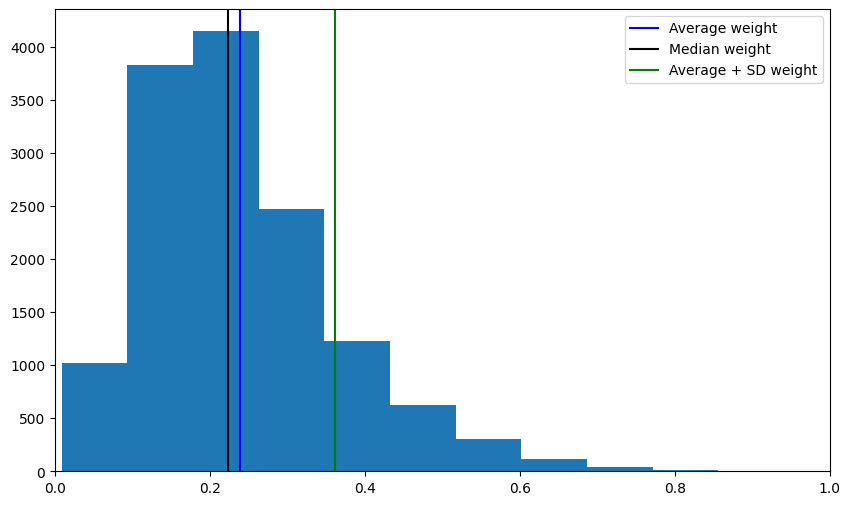

In [4]:
em.plot_distribution_of_all_weights()

Distribution-% of predicted scores:  [8.960963575678422, 34.465244521840084, 31.410535481062258, 14.4826585401248, 6.733420403424757, 2.7064286750834423, 0.9432593237556233, 0.28297779712668697, 0.014511681903932667, 0.0]


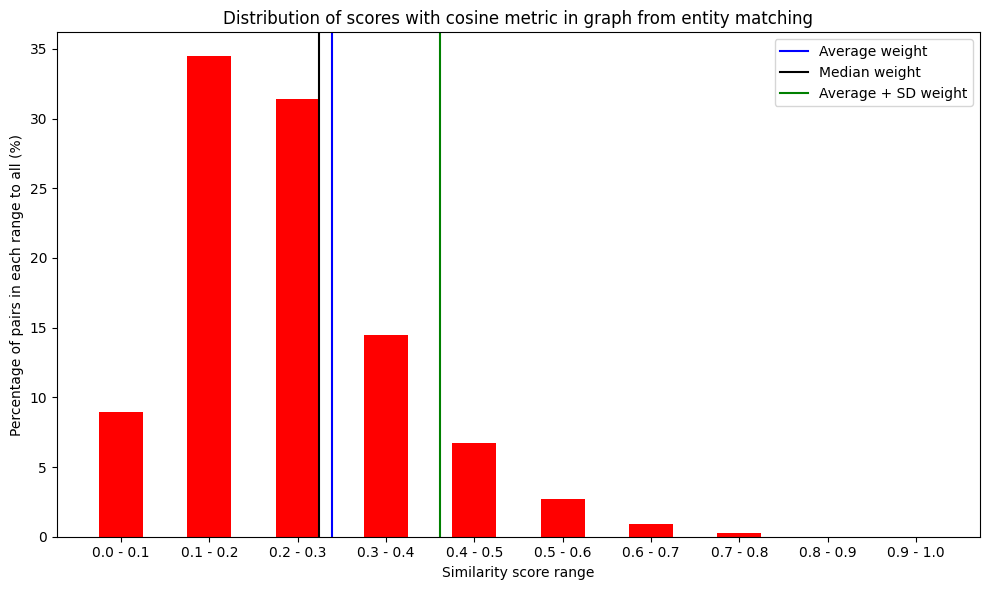

In [5]:
em.plot_distribution_of_scores()

## Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [6]:
from pyjedai.clustering import UniqueMappingClustering


In [7]:
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)
umc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Method:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
	Similarity Threshold: 0.1
Runtime: 0.0654 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     92.56% 
	Recall:        87.92%
	F1-score:      90.18%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 946
	False positives: 76
	True negatives: 1156570
	False negatives: 130
	Total comparisons: 1022
─────────────────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 92.56360078277886,
 'Recall %': 87.9182156133829,
 'F1 %': 90.1811248808389,
 'True Positives': 946,
 'False Positives': 76,
 'True Negatives': 1156570,
 'False Negatives': 130}

<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>